In [1]:
!pip install kagglehub

# Import Library

In [1]:
import kagglehub
import os
import shutil

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, classification_report

In [2]:
path = kagglehub.dataset_download("architsharma01/loan-approval-prediction-dataset")

print("Konten direktori utama:")
print(os.listdir(path))
for root, dirs, _ in os.walk(path):
    print(root)

Konten direktori utama:
['loan_approval_dataset.csv']
/kaggle/input/loan-approval-prediction-dataset


In [3]:
df = pd.read_csv(f"{path}/loan_approval_dataset.csv")
df.columns = df.columns.str.strip()
df.head()

loan_id  no_of_dependents      education self_employed  income_annum  \
0        1                 2       Graduate            No       9600000   
1        2                 0   Not Graduate           Yes       4100000   
2        3                 3       Graduate            No       9100000   
3        4                 3       Graduate            No       8200000   
4        5                 5   Not Graduate           Yes       9800000   

   loan_amount  loan_term  cibil_score  residential_assets_value  \
0     29900000         12          778                   2400000   
1     12200000          8          417                   2700000   
2     29700000         20          506                   7100000   
3     30700000          8          467                  18200000   
4     24200000         20          382                  12400000   

   commercial_assets_value  luxury_assets_value  bank_asset_value loan_status  
0                 17600000             22700000           8000000    Approved  
1                  2200000              8800000           3300000    Rejected  
2                  4500000             33300000          12800000    Rejected  
3                  3300000             23300000           7900000    Rejected  
4                  8200000             29400000           5000000    Rejected

# EDA

## Data Understanding

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   loan_id                   4269 non-null   int64 
 1   no_of_dependents          4269 non-null   int64 
 2   education                 4269 non-null   object
 3   self_employed             4269 non-null   object
 4   income_annum              4269 non-null   int64 
 5   loan_amount               4269 non-null   int64 
 6   loan_term                 4269 non-null   int64 
 7   cibil_score               4269 non-null   int64 
 8   residential_assets_value  4269 non-null   int64 
 9   commercial_assets_value   4269 non-null   int64 
 10  luxury_assets_value       4269 non-null   int64 
 11  bank_asset_value          4269 non-null   int64 
 12  loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


In [ ]:
df.describe().T

count          mean           std       min  \
loan_id                   4269.0  2.135000e+03  1.232498e+03       1.0   
no_of_dependents          4269.0  2.498712e+00  1.695910e+00       0.0   
income_annum              4269.0  5.059124e+06  2.806840e+06  200000.0   
loan_amount               4269.0  1.513345e+07  9.043363e+06  300000.0   
loan_term                 4269.0  1.090045e+01  5.709187e+00       2.0   
cibil_score               4269.0  5.999361e+02  1.724304e+02     300.0   
residential_assets_value  4269.0  7.472617e+06  6.503637e+06 -100000.0   
commercial_assets_value   4269.0  4.973155e+06  4.388966e+06       0.0   
luxury_assets_value       4269.0  1.512631e+07  9.103754e+06  300000.0   
bank_asset_value          4269.0  4.976692e+06  3.250185e+06       0.0   

                                25%         50%         75%         max  
loan_id                      1068.0      2135.0      3202.0      4269.0  
no_of_dependents                1.0         3.0         4.0         5.0  
income_annum              2700000.0   5100000.0   7500000.0   9900000.0  
loan_amount               7700000.0  14500000.0  21500000.0  39500000.0  
loan_term                       6.0        10.0        16.0        20.0  
cibil_score                   453.0       600.0       748.0       900.0  
residential_assets_value  2200000.0   5600000.0  11300000.0  29100000.0  
commercial_assets_value   1300000.0   3700000.0   7600000.0  19400000.0  
luxury_assets_value       7500000.0  14600000.0  21700000.0  39200000.0  
bank_asset_value          2300000.0   4600000.0   7100000.0  14700000.0

In [ ]:
null_val = df.isna().sum()
duplicated_data = df.duplicated().sum()
print("===============================")
print(f"Jumlah Missing Values: \n{null_val}")
print(f"Jumlah Data Duplikat: {duplicated_data}")
print("===============================")

Jumlah Missing Values: 
loan_id                     0
no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64
Jumlah Data Duplikat: 0


## Univariate Analysis

In [4]:
data = df.copy()
data = data.drop(columns='loan_id')
num_col = data.select_dtypes(include=['int64']).columns
cat_col = data.select_dtypes(include='object').columns

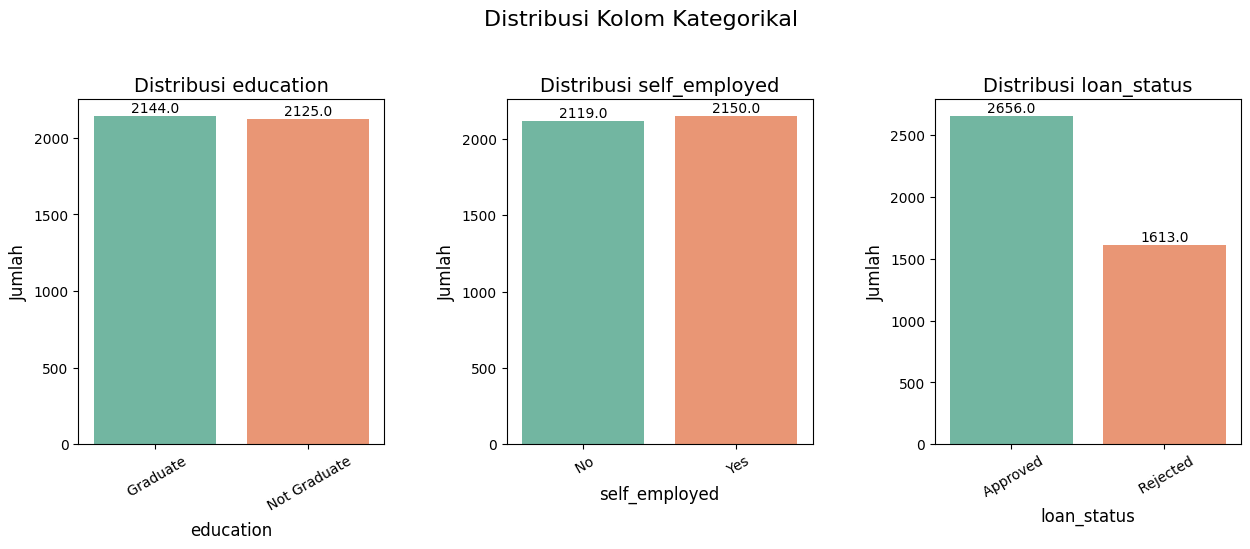

In [ ]:
# Pilih palet warna
palette = sns.color_palette("Set2")

# Tentukan jumlah subplot berdasarkan jumlah kolom kategorikal
n_col = len(cat_col)
n_rows = (n_col + 2) // 2  # 2 kolom per baris
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs = axs.flatten()

# Loop untuk membuat countplot
for i, kolom in enumerate(cat_col):
    ax = axs[i]
    sns.countplot(data=df, x=kolom, palette=palette, ax=ax)
    ax.set_title(f"Distribusi {kolom}", fontsize=14, fontweight='normal')
    ax.set_xlabel(kolom, fontsize=12)
    ax.set_ylabel("Jumlah", fontsize=12)
    ax.tick_params(axis='x', rotation=30)

    # Tambahkan label di atas setiap bar
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10, color='black')

# Sembunyikan subplot yang tidak terpakai
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.suptitle("Distribusi Kolom Kategorikal", fontsize=16, fontweight='normal')
plt.subplots_adjust(wspace=0.4, top=0.8)  # atur jarak horizontal dan ruang atas
plt.show()


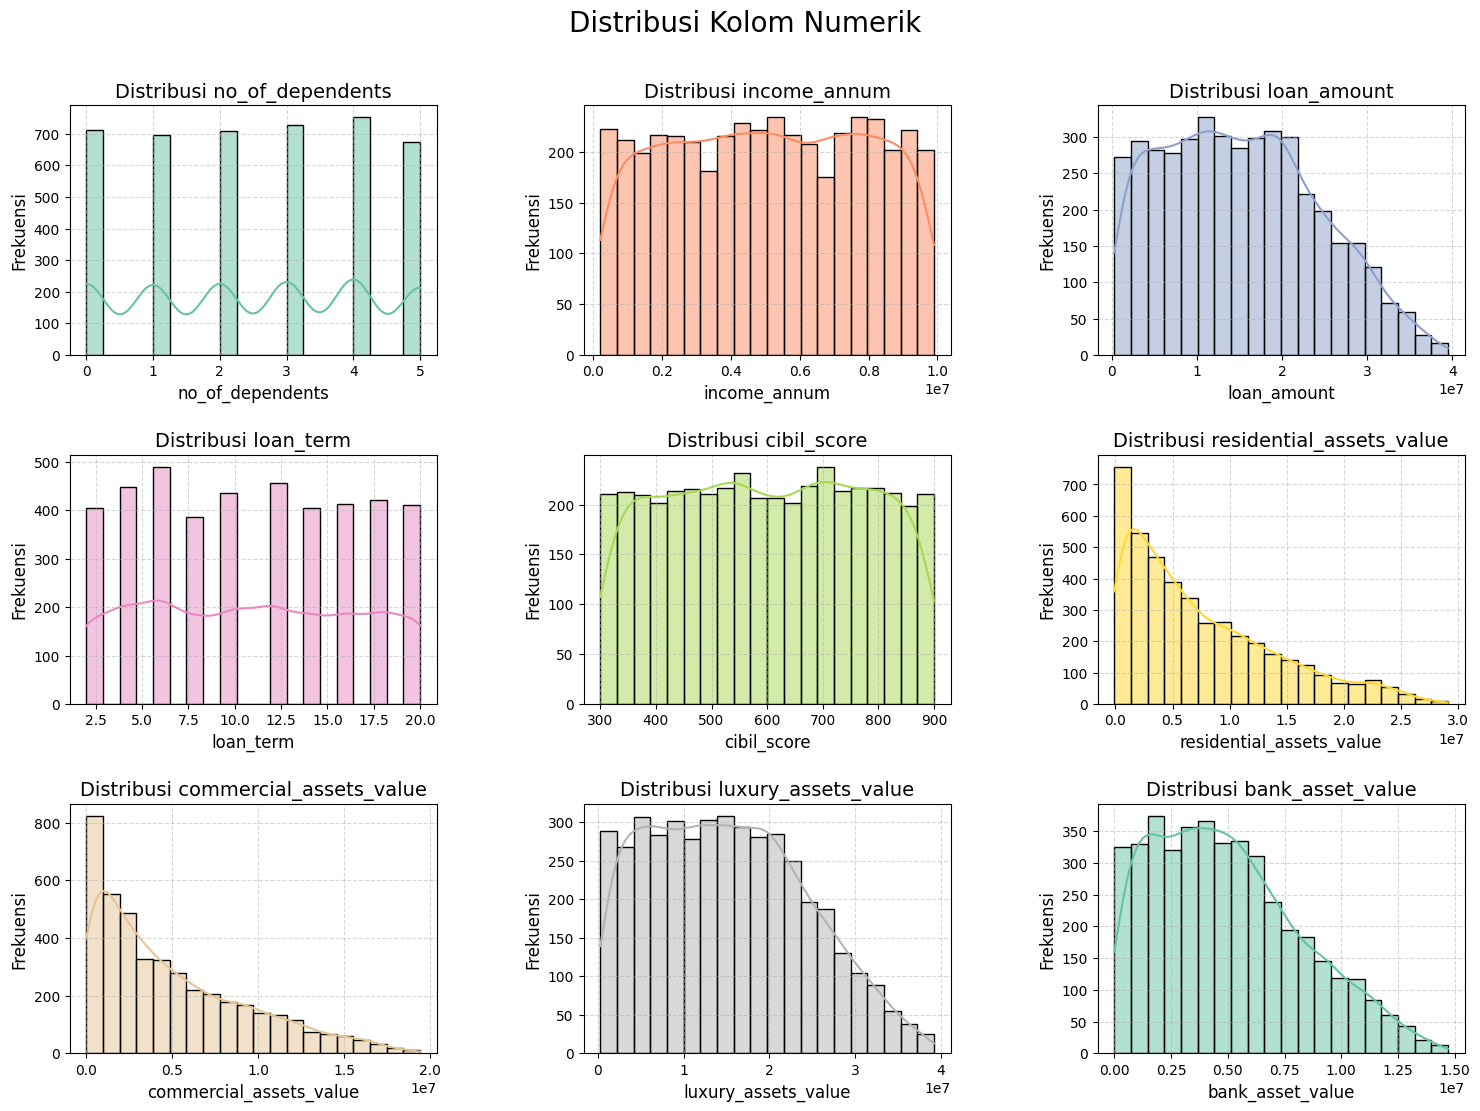

In [ ]:
# Palet warna (tidak begitu berpengaruh untuk histogram, tapi tetap bisa digunakan)
palette = sns.color_palette("Set2")

# Ganti cat_col dengan num_col
n_col = len(num_col)
n_cols = 3  # jumlah kolom subplot per baris
n_rows = (n_col + n_cols - 1) // n_cols

# Buat subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
axs = axs.flatten()

# Loop untuk membuat histogram
for i, kolom in enumerate(num_col):
    ax = axs[i]
    sns.histplot(data=df, x=kolom, bins=20, kde=True, color=palette[i % len(palette)], ax=ax)
    ax.set_title(f"Distribusi {kolom}", fontsize=14, fontweight='normal')
    ax.set_xlabel(kolom, fontsize=12)
    ax.set_ylabel("Frekuensi", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.5)

# Sembunyikan subplot kosong (jika jumlah kolom numerik tidak habis dibagi n_cols)
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.suptitle("Distribusi Kolom Numerik", fontsize=20, fontweight='normal')
plt.subplots_adjust(wspace=0.4, hspace=0.4, top=0.9)
plt.show()


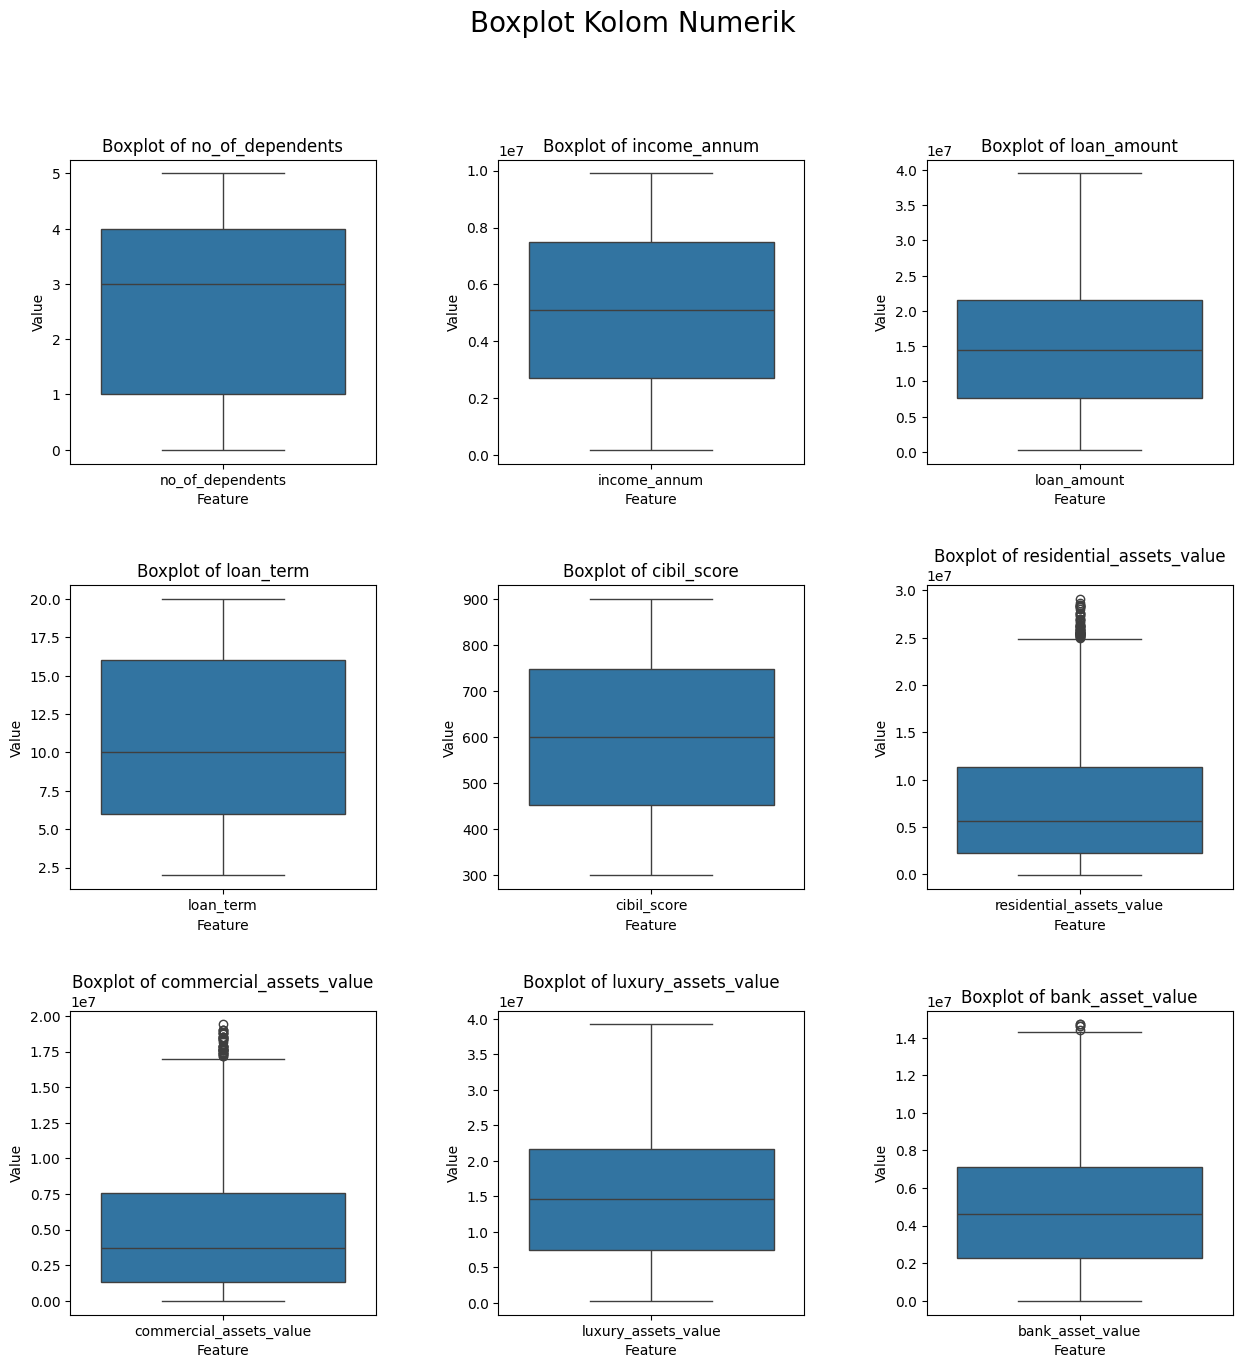

In [ ]:
# Hitung jumlah subplot
n_cols = 3
n_rows = math.ceil(len(num_col) / n_cols)
df_long = df[num_col].melt(var_name='Feature', value_name='Value')
# Buat figure dan axes
fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
axs = axs.flatten()

# Buat boxplot untuk setiap fitur numerik
for i, col in enumerate(num_col):
    sns.boxplot(data=df_long[df_long['Feature'] == col], x='Feature', y='Value', ax=axs[i])
    axs[i].set_title(f'Boxplot of {col}')
    # axs[i].tick_params(axis='x', rotation=45)

# Hapus axis kosong jika ada
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.suptitle("Boxplot Kolom Numerik", fontsize=20, fontweight='normal')
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()


## Multivariate Analysis

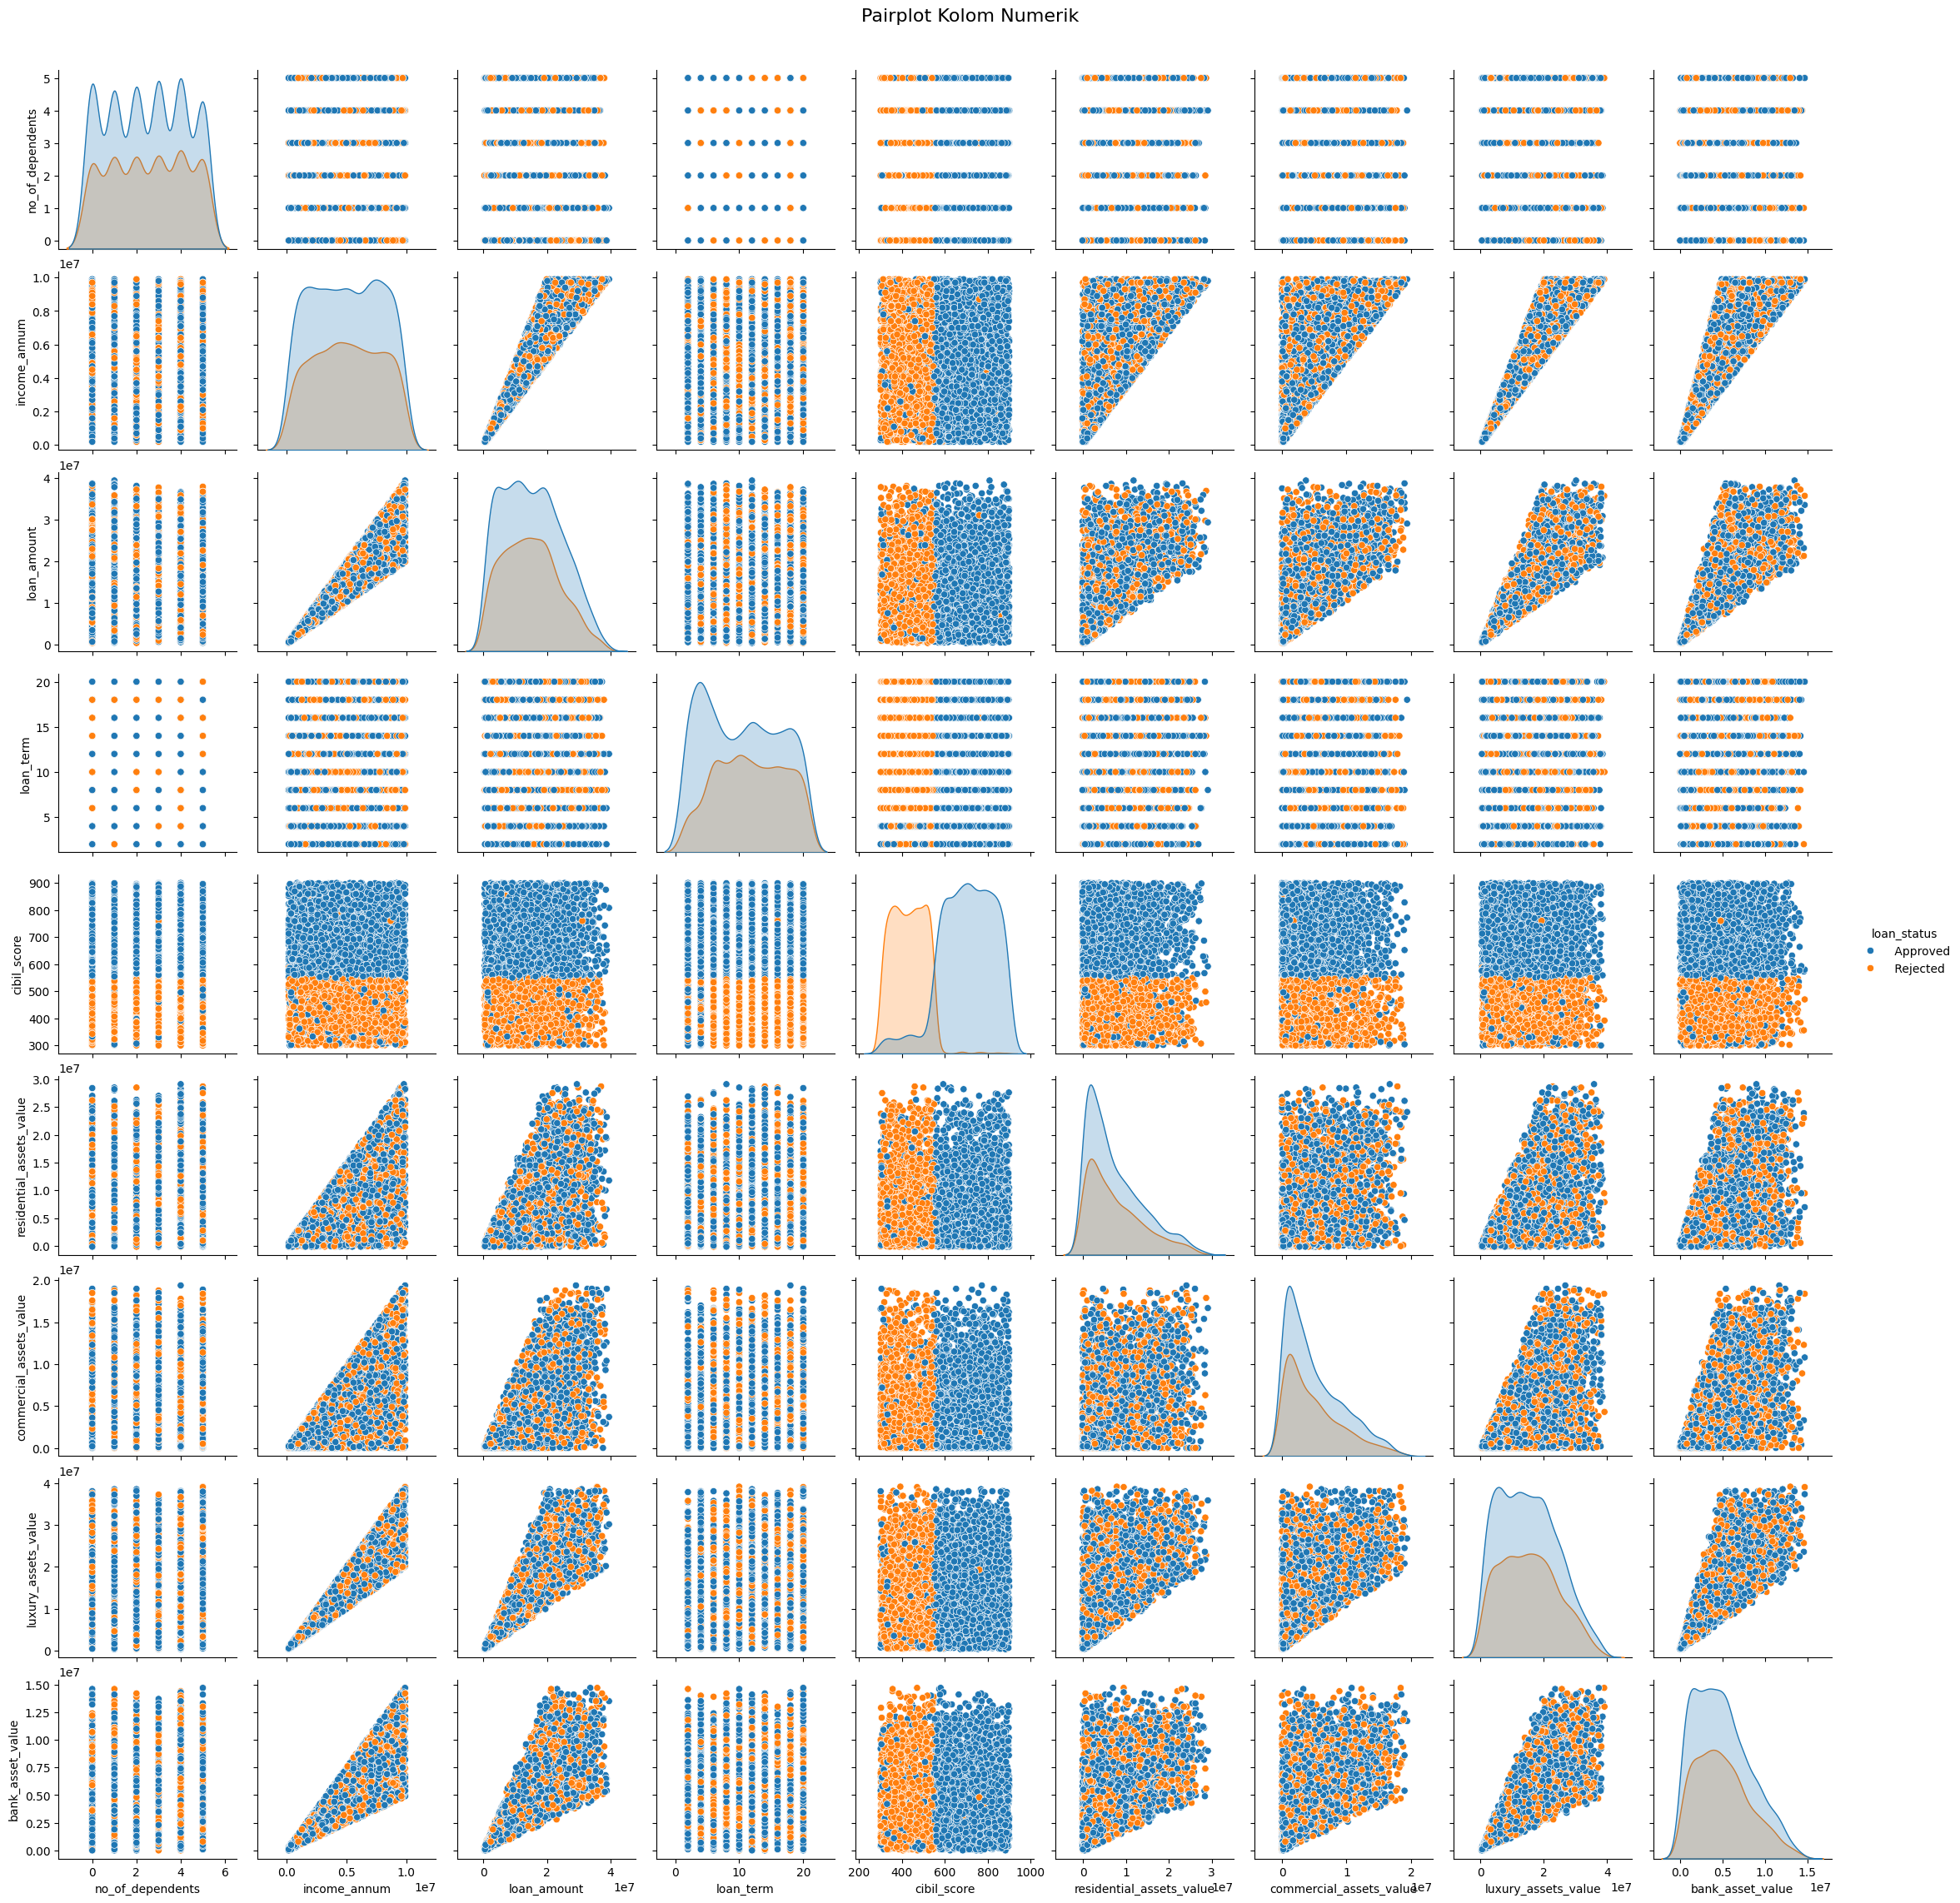

In [ ]:
sns.pairplot(data, hue='loan_status')
plt.suptitle("Pairplot Kolom Numerik", fontsize=16, y=1.02)
plt.show()

## Analisis Korelasi

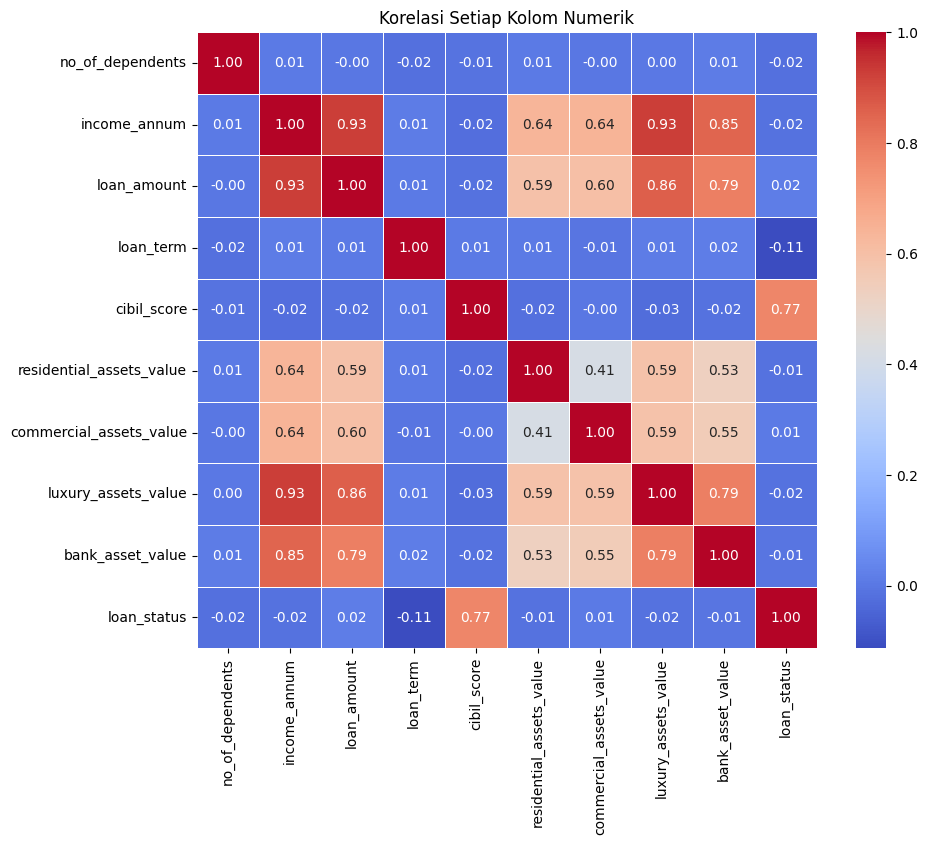

In [ ]:
data_corr = data.copy()
data_corr['loan_status'] = data_corr['loan_status'].map({' Approved':1, ' Rejected':0})

plt.figure(figsize=(10, 8))
correlation_matrix = data_corr.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Korelasi Setiap Kolom Numerik")
plt.show()

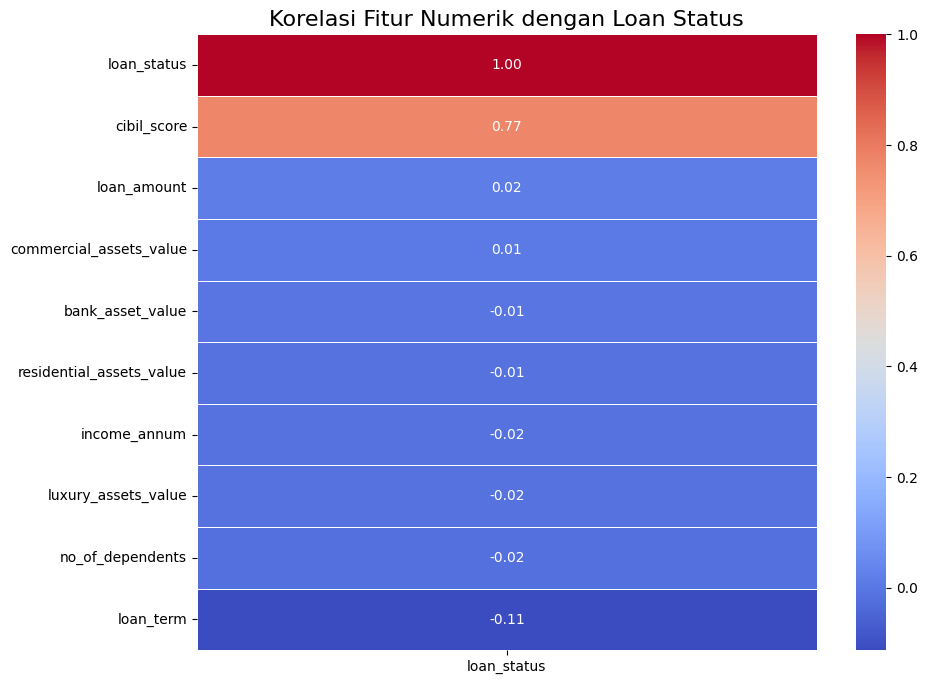

In [ ]:
# Salin dataframe agar tidak mengubah aslinya
df_corr = data.copy()
df_corr['loan_status'] = df_corr['loan_status'].map({' Approved': 1, ' Rejected': 0})

# Ambil hanya kolom numerik + target
corr = df_corr.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr[['loan_status']].sort_values(by='loan_status', ascending=False),
            annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Korelasi Fitur Numerik dengan Loan Status", fontsize=16, fontweight='normal')
plt.show()



# Data Pre Processing (Data Preparation)

## Data Cleaning

In [ ]:
df.describe().T

count          mean           std       min  \
loan_id                   4269.0  2.135000e+03  1.232498e+03       1.0   
no_of_dependents          4269.0  2.498712e+00  1.695910e+00       0.0   
income_annum              4269.0  5.059124e+06  2.806840e+06  200000.0   
loan_amount               4269.0  1.513345e+07  9.043363e+06  300000.0   
loan_term                 4269.0  1.090045e+01  5.709187e+00       2.0   
cibil_score               4269.0  5.999361e+02  1.724304e+02     300.0   
residential_assets_value  4269.0  7.472617e+06  6.503637e+06 -100000.0   
commercial_assets_value   4269.0  4.973155e+06  4.388966e+06       0.0   
luxury_assets_value       4269.0  1.512631e+07  9.103754e+06  300000.0   
bank_asset_value          4269.0  4.976692e+06  3.250185e+06       0.0   

                                25%         50%         75%         max  
loan_id                      1068.0      2135.0      3202.0      4269.0  
no_of_dependents                1.0         3.0         4.0         5.0  
income_annum              2700000.0   5100000.0   7500000.0   9900000.0  
loan_amount               7700000.0  14500000.0  21500000.0  39500000.0  
loan_term                       6.0        10.0        16.0        20.0  
cibil_score                   453.0       600.0       748.0       900.0  
residential_assets_value  2200000.0   5600000.0  11300000.0  29100000.0  
commercial_assets_value   1300000.0   3700000.0   7600000.0  19400000.0  
luxury_assets_value       7500000.0  14600000.0  21700000.0  39200000.0  
bank_asset_value          2300000.0   4600000.0   7100000.0  14700000.0

In [6]:
(data['residential_assets_value'] < 0).sum()

np.int64(28)

In [5]:
# data = df.copy()
data = data[data['residential_assets_value'] >= 0]
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4241 entries, 0 to 4268
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   no_of_dependents          4241 non-null   int64 
 1   education                 4241 non-null   object
 2   self_employed             4241 non-null   object
 3   income_annum              4241 non-null   int64 
 4   loan_amount               4241 non-null   int64 
 5   loan_term                 4241 non-null   int64 
 6   cibil_score               4241 non-null   int64 
 7   residential_assets_value  4241 non-null   int64 
 8   commercial_assets_value   4241 non-null   int64 
 9   luxury_assets_value       4241 non-null   int64 
 10  bank_asset_value          4241 non-null   int64 
 11  loan_status               4241 non-null   object
dtypes: int64(9), object(3)
memory usage: 430.7+ KB


## Mengatasi Pencilan (Outlier)

In [6]:
# data = df.drop(columns='loan_id')
numeric_columns = data.select_dtypes(include='int64').columns

for kolom in numeric_columns:
  q1 = data[kolom].quantile(0.25)
  q3 = data[kolom].quantile(0.75)
  iqr = q3-q1

  low_bound = q1 - 1.5 * iqr
  up_bound = q3 + 1.5 * iqr
  data = data[(data[kolom] > low_bound) & (data[kolom] < up_bound)]

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4148 entries, 1 to 4268
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   no_of_dependents          4148 non-null   int64 
 1   education                 4148 non-null   object
 2   self_employed             4148 non-null   object
 3   income_annum              4148 non-null   int64 
 4   loan_amount               4148 non-null   int64 
 5   loan_term                 4148 non-null   int64 
 6   cibil_score               4148 non-null   int64 
 7   residential_assets_value  4148 non-null   int64 
 8   commercial_assets_value   4148 non-null   int64 
 9   luxury_assets_value       4148 non-null   int64 
 10  bank_asset_value          4148 non-null   int64 
 11  loan_status               4148 non-null   object
dtypes: int64(9), object(3)
memory usage: 421.3+ KB


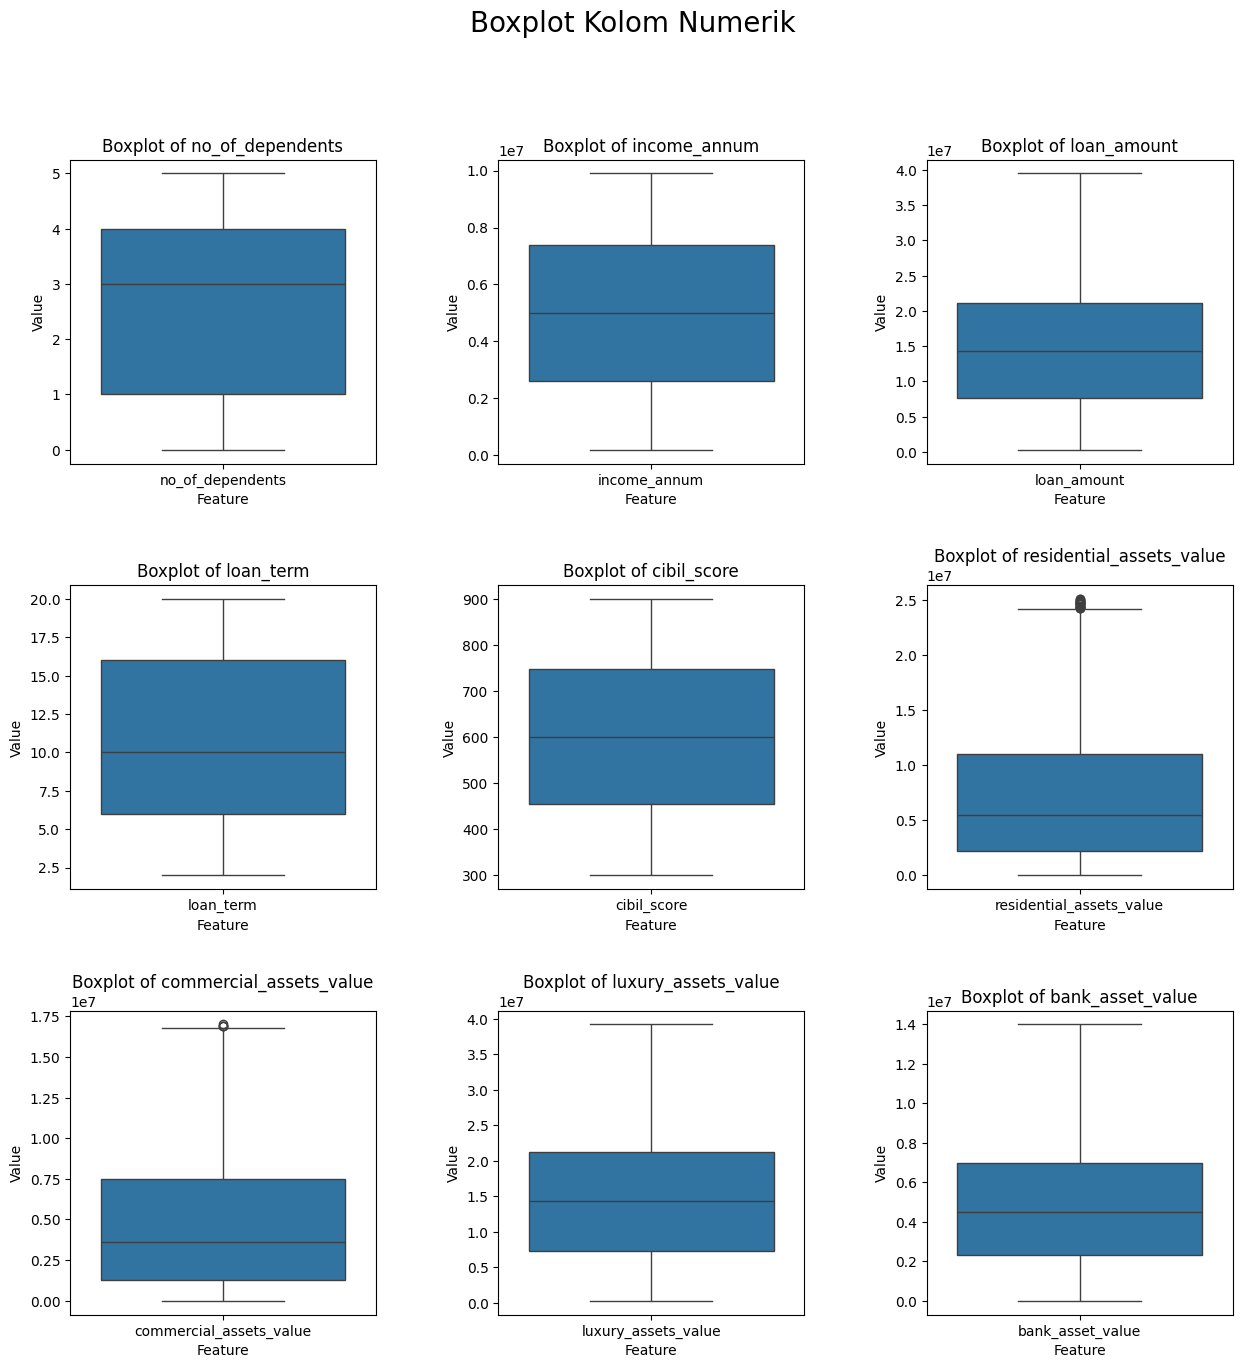

In [ ]:
# Hitung jumlah subplot
n_cols = 3
n_rows = math.ceil(len(numeric_columns) / n_cols)
data_long = data[numeric_columns].melt(var_name='Feature', value_name='Value')

# Buat figure dan axes
fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
axs = axs.flatten()

# Buat boxplot untuk setiap fitur numerik
for i, col in enumerate(numeric_columns):
    sns.boxplot(data=data_long[data_long['Feature'] == col], x='Feature', y='Value', ax=axs[i])
    axs[i].set_title(f'Boxplot of {col}')
    # axs[i].tick_params(axis='x', rotation=45)

# Hapus axis kosong jika ada
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.suptitle("Boxplot Kolom Numerik", fontsize=20, fontweight='normal')
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()


## Encoding Categorical Columns

In [ ]:
for kolom in cat_col:
  print(f"{kolom}: {data[kolom].unique()}")

education: [' Not Graduate' ' Graduate']
self_employed: [' Yes' ' No']
loan_status: [' Rejected' ' Approved']


In [ ]:
data[cat_col].head()

education self_employed loan_status
1   Not Graduate           Yes    Rejected
2       Graduate            No    Rejected
3       Graduate            No    Rejected
4   Not Graduate           Yes    Rejected
5       Graduate           Yes    Rejected

In [7]:
# data = df.drop(columns='loan_id')
data['education'] = data['education'].map({' Graduate': 1, ' Not Graduate': 0})
data['self_employed'] = data['self_employed'].map({' Yes': 1, ' No': 0})
data['loan_status'] = data['loan_status'].map({' Approved': 1, ' Rejected': 0})
data[cat_col].head()

education  self_employed  loan_status
1          0              1            0
2          1              0            0
3          1              0            0
4          0              1            0
5          1              1            0

## Data Standardization

In [ ]:
data.describe().T

count          mean           std       min  \
no_of_dependents          4148.0  2.499759e+00  1.694329e+00       0.0   
income_annum              4148.0  4.976230e+06  2.755451e+06  200000.0   
loan_amount               4148.0  1.490921e+07  8.914531e+06  300000.0   
loan_term                 4148.0  1.089007e+01  5.708494e+00       2.0   
cibil_score               4148.0  5.999298e+02  1.721955e+02     300.0   
residential_assets_value  4148.0  7.244455e+06  6.144507e+06       0.0   
commercial_assets_value   4148.0  4.834161e+06  4.210183e+06       0.0   
luxury_assets_value       4148.0  1.490137e+07  8.977879e+06  300000.0   
bank_asset_value          4148.0  4.880231e+06  3.168089e+06       0.0   

                                 25%         50%         75%         max  
no_of_dependents                1.00         3.0         4.0         5.0  
income_annum              2600000.00   5000000.0   7400000.0   9900000.0  
loan_amount               7600000.00  14300000.0  21100000.0  39500000.0  
loan_term                       6.00        10.0        16.0        20.0  
cibil_score                   453.75       600.0       747.0       900.0  
residential_assets_value  2200000.00   5500000.0  11000000.0  25100000.0  
commercial_assets_value   1300000.00   3600000.0   7500000.0  17000000.0  
luxury_assets_value       7375000.00  14300000.0  21225000.0  39200000.0  
bank_asset_value          2300000.00   4500000.0   7000000.0  14000000.0

In [8]:
scaler = MinMaxScaler()
scaled_numeric = pd.DataFrame(
    scaler.fit_transform(data[num_col]),
    columns=num_col,
    index=data.index
)

# Gabungkan kembali dengan kolom kategorikal
data_scaled = pd.concat([scaled_numeric, data[cat_col]], axis=1)

# Tampilkan hasil
scaled_numeric.describe().T

count      mean       std  min       25%       50%  \
no_of_dependents          4148.0  0.499952  0.338866  0.0  0.200000  0.600000   
income_annum              4148.0  0.492395  0.284067  0.0  0.247423  0.494845   
loan_amount               4148.0  0.372684  0.227412  0.0  0.186224  0.357143   
loan_term                 4148.0  0.493893  0.317139  0.0  0.222222  0.444444   
cibil_score               4148.0  0.499883  0.286993  0.0  0.256250  0.500000   
residential_assets_value  4148.0  0.288624  0.244801  0.0  0.087649  0.219124   
commercial_assets_value   4148.0  0.284362  0.247658  0.0  0.076471  0.211765   
luxury_assets_value       4148.0  0.375357  0.230794  0.0  0.181877  0.359897   
bank_asset_value          4148.0  0.348588  0.226292  0.0  0.164286  0.321429   

                               75%  max  
no_of_dependents          0.800000  1.0  
income_annum              0.742268  1.0  
loan_amount               0.530612  1.0  
loan_term                 0.777778  1.0  
cibil_score               0.745000  1.0  
residential_assets_value  0.438247  1.0  
commercial_assets_value   0.441176  1.0  
luxury_assets_value       0.537918  1.0  
bank_asset_value          0.500000  1.0

## Handling Imbalanced Data (Oversampling)

In [9]:
# data = df.drop(columns='loan_id')
X = data_scaled.drop(columns='loan_status')
y = data_scaled['loan_status']

# Melihat distribusi kelas awal
count_0 = np.sum(y == 0)
count_1 = np.sum(y == 1)
print("Sebelum oversampling:")
print(f"Jumlah baris data yang bernilai '0' ada sebanyak: {count_0}")
print(f"Jumlah baris data yang bernilai '1' ada sebanyak: {count_1}")
print(f"Persentase kelas 0: {count_0/(count_0+count_1)*100:.2f}%")
print(f"Persentase kelas 1: {count_1/(count_0+count_1)*100:.2f}%")

Sebelum oversampling:
Jumlah baris data yang bernilai '0' ada sebanyak: 1563
Jumlah baris data yang bernilai '1' ada sebanyak: 2585
Persentase kelas 0: 37.68%
Persentase kelas 1: 62.32%


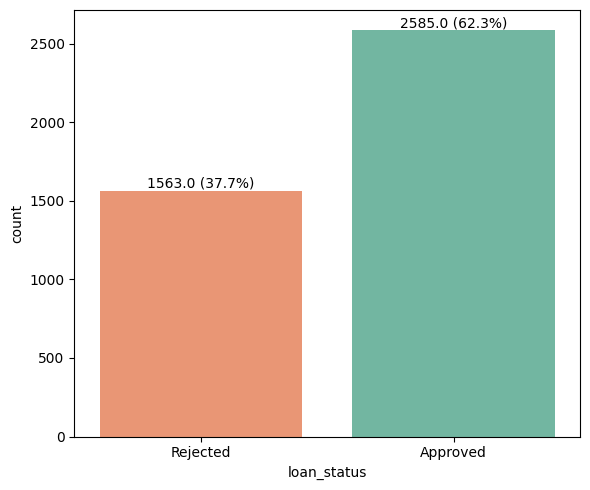

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Salin data dan ubah label
df_imbalanced = data_scaled.copy()
df_imbalanced['loan_status'] = df_imbalanced['loan_status'].map({1: 'Approved', 0: 'Rejected'})

# Tentukan warna berdasarkan label
palette = sns.color_palette("Set2")
custom_palette = {'Approved': palette[0], 'Rejected': palette[1]}


# Plot
fig, axs = plt.subplots(figsize=(6, 5))
sns.countplot(data=df_imbalanced, x='loan_status', palette=custom_palette, ax=axs)

# Tambahkan label jumlah dan persentase
total = len(df_imbalanced)
for p in axs.patches:
    count = p.get_height()
    percentage = 100 * count / total
    axs.annotate(f'{count} ({percentage:.1f}%)',
                 (p.get_x() + p.get_width() / 2., count),
                 ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

In [10]:
# Over-sampling dengan keseimbangan penuh
over_sampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = over_sampler.fit_resample(X, y)


In [ ]:
# Melihat distribusi kelas setelah oversampling
count_0 = np.sum(y_resampled == 0)
count_1 = np.sum(y_resampled == 1)
print("\nSetelah oversampling:")
print(f"Jumlah baris data yang bernilai '0' ada sebanyak: {count_0}")
print(f"Jumlah baris data yang bernilai '1' ada sebanyak: {count_1}")
print(f"Persentase kelas 0: {count_0/(count_0+count_1)*100:.2f}%")
print(f"Persentase kelas 1: {count_1/(count_0+count_1)*100:.2f}%")


Setelah oversampling:
Jumlah baris data yang bernilai '0' ada sebanyak: 2585
Jumlah baris data yang bernilai '1' ada sebanyak: 2585
Persentase kelas 0: 50.00%
Persentase kelas 1: 50.00%


In [ ]:
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)

# Menambahkan kolom target dari y_resampled
df_resampled['loan_status'] = y_resampled

df_resampled.to_csv('npl_data.csv', index=False)

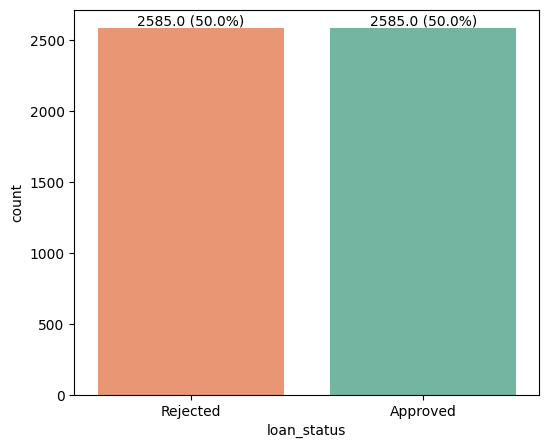

In [ ]:
df_y = pd.DataFrame({'loan_status': y_resampled})
df_y['loan_status'] = df_y['loan_status'].map({1:'Approved', 0:"Rejected"})

# Plot
palette = sns.color_palette("Set2")
custom_palette = {'Approved': palette[0], 'Rejected': palette[1]}
fig, axs = plt.subplots(figsize=(6, 5))
# Pilih palet warna
sns.countplot(data=df_y, x='loan_status', palette=custom_palette)
total = len(df_y)
for p in axs.patches:
  count = p.get_height()
  percentage = 100 * count / total
  axs.annotate(f'{count} ({percentage:.1f}%)',
              (p.get_x() + p.get_width() / 2., count),
              ha='center', va='bottom', fontsize=10, color='black')


## Data Splitting

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)
print(X_train.shape)
print(y_train.shape)

(4136, 11)
(4136,)


# Modeling

In [12]:
# Daftar model yang digunakan
models = {
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
}

# Dictionary untuk menyimpan hasil evaluasi
results = []

# Evaluasi setiap model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]  # Probabilitas kelas 1
    else:
        y_scores = model.decision_function(X_test)   # Untuk model SVM (jika tidak pakai probability=True)

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_scores)
    })


In [13]:
# Ubah hasil ke dalam bentuk DataFrame
results_df = pd.DataFrame(results)

# Tampilkan hasil
results_df = results_df.sort_values(by='Accuracy', ascending=False)
results_df = results_df.reset_index(drop=True)
results_df


Model  Accuracy  Precision    Recall  F1 Score   ROC-AUC
0  Random Forest  0.991296   1.000000  0.982592  0.991220  0.999955
1        XGBoost  0.989362   1.000000  0.978723  0.989247  0.999944
2            SVM  0.939072   0.969008  0.907157  0.937063  0.984926

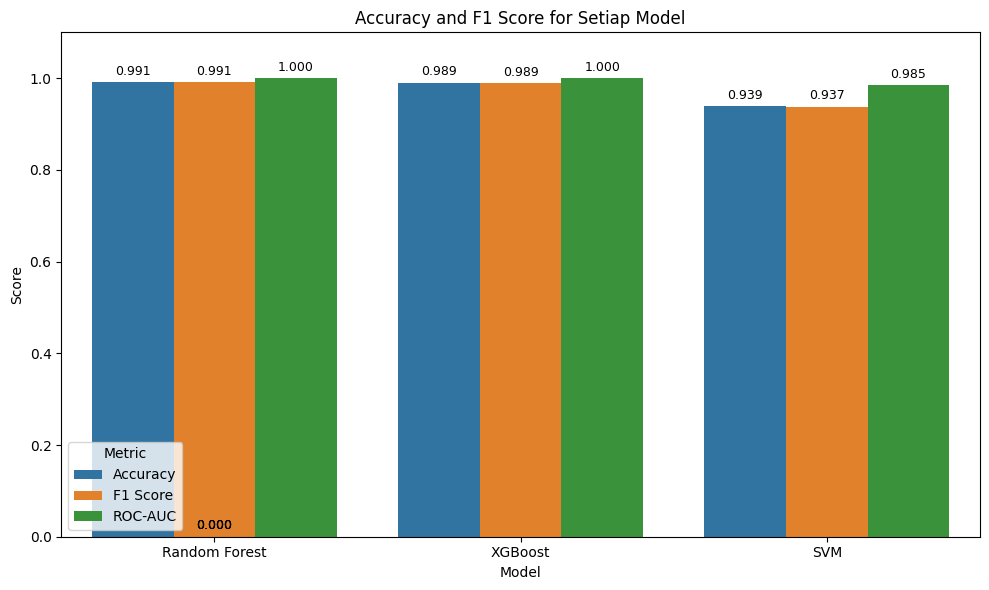

In [14]:
# Ubah dataframe ke format long agar bisa digunakan di seaborn barplot
results_long = results_df.melt(id_vars='Model', value_vars=['Accuracy', 'F1 Score', 'ROC-AUC'],
                               var_name='Metric', value_name='Score')

# Buat bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=results_long, x='Model', y='Score', hue='Metric')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2,
            height + 0.01,
            f'{height:.3f}',
            ha='center', va='bottom', fontsize=9)
# Tambahkan judul dan label
plt.title('Accuracy and F1 Score for Setiap Model')
plt.ylabel('Score')
plt.ylim(0, 1.1)  # Tambah batas atas agar label tidak terpotong
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


#  Hyperparameter Tuning (Grid Search)

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Parameter grid untuk setiap model
param_grid = {
    "SVM": {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    "Random Forest": {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 10],
        'min_samples_leaf': [1, 5]
    },
    "XGBoost": {
        'n_estimators': [100, 200],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1]
    }
}

# Model dictionary
models_grid = {
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
}

# Tempat menyimpan model terbaik
best_models_grid = {}

# Melakukan grid search untuk setiap model
for name in models_grid:
    print(f"Tuning model: {name}")
    grid = GridSearchCV(models_grid[name], param_grid[name], cv=5, n_jobs=-1, scoring='accuracy')

    # Gunakan data yang sudah discale untuk SVM, data asli untuk RF dan XGBoost
    grid.fit(X_train, y_train)

    print(f"Best parameters for {name}: {grid.best_params_}")
    print(f"Best score for {name}: {grid.best_score_:.4f}\n")
    best_models_grid[name] = grid.best_estimator_



Tuning model: SVM
Best parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best score for SVM: 0.9521

Tuning model: Random Forest
Best parameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best score for Random Forest: 0.9848

Tuning model: XGBoost
Best parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.8}
Best score for XGBoost: 0.9891



In [18]:
for name, model in best_models_grid.items():
  y_pred = best_models_grid[name].predict(X_test)
  print(f"Test accuracy for {name}: {accuracy_score(y_test, y_pred):.4f}")
  print(f"Parameter dari model {name}:")
  print(model.get_params())
  print("-" * 50)

Test accuracy for SVM: 0.9603
Parameter dari model SVM:
{'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
--------------------------------------------------
Test accuracy for Random Forest: 0.9855
Parameter dari model Random Forest:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
--------------------------------------------------
Test accuracy for XGBoost: 0.9903
Parameter dari model XGBoost:
{'objective

In [ ]:
grid_results = []

# Evaluasi setiap model
for name, model in best_models_grid.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    grid_results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred)
    })

In [ ]:
grid_results_df = pd.DataFrame(grid_results)

# Tampilkan hasil
grid_results_df = grid_results_df.sort_values(by='Accuracy', ascending=False)
grid_results_df = grid_results_df.reset_index(drop=True)
grid_results_df

Model  Accuracy  Precision    Recall  F1 Score
0        XGBoost  0.990329   1.000000  0.980658  0.990234
1  Random Forest  0.985493   0.996047  0.974855  0.985337
2            SVM  0.960348   0.977912  0.941973  0.959606

# Best Model

In [54]:
# Daftar model yang digunakan
best_models = {
    "SVM": SVC(
        C=10, kernel='rbf',
        gamma='scale',
        random_state=32),
    "Random Forest": RandomForestClassifier(random_state=32),
    "XGBoost": XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        learning_rate= 0.2,
        max_depth= 10,
        n_estimators= 100,
        subsample= 0.8,
        random_state=32),
}

# Dictionary untuk menyimpan hasil evaluasi
best_results = []

# Evaluasi setiap model
for name, model in best_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]  # Probabilitas kelas 1
    else:
        y_scores = model.decision_function(X_test)   # Untuk model SVM (jika tidak pakai probability=True)

    fpr, tpr, _ = roc_curve(y_test, y_scores)
    auc = roc_auc_score(y_test, y_scores)
    best_results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC-AUC": auc
    })
    print(f"Test accuracy for {name}: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Parameter dari model {name}:")
    print(model.get_params())
    print("-" * 50)


Test accuracy for SVM: 0.9603
Parameter dari model SVM:
{'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 32, 'shrinking': True, 'tol': 0.001, 'verbose': False}
--------------------------------------------------
Test accuracy for Random Forest: 0.9913
Parameter dari model Random Forest:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 32, 'verbose': 0, 'warm_start': False}
--------------------------------------------------
Test accuracy for XGBoost: 0.9932
Parameter dari model XGBoost:
{'objective

In [55]:
# Ubah hasil ke dalam bentuk DataFrame
best_results_df = pd.DataFrame(best_results)

# Tampilkan hasil
best_results_df = best_results_df.sort_values(by='Accuracy', ascending=False)
best_results_df = best_results_df.reset_index(drop=True)
best_results_df


Model  Accuracy  Precision    Recall  F1 Score   ROC-AUC
0        XGBoost  0.993230   1.000000  0.986460  0.993184  0.999892
1  Random Forest  0.991296   1.000000  0.982592  0.991220  0.999981
2            SVM  0.960348   0.977912  0.941973  0.959606  0.991994

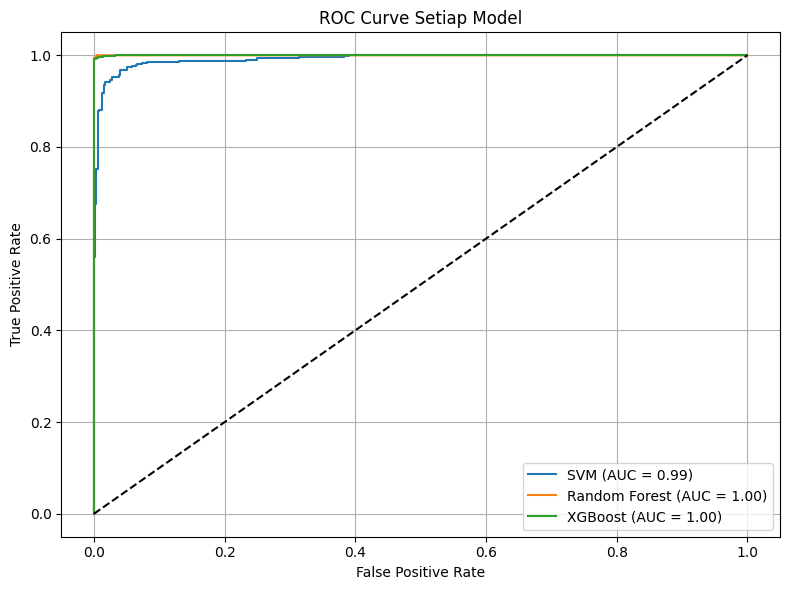

In [58]:
plt.figure(figsize=(8, 6))
for name, model in best_models.items():
    # Training
    model.fit(X_train, y_train)

    # Prediction
    y_pred = model.predict(X_test)

    # ROC AUC
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]  # Probabilitas kelas 1
    else:
        y_scores = model.decision_function(X_test)   # Untuk model SVM (jika tidak pakai probability=True)

    fpr, tpr, _ = roc_curve(y_test, y_scores)
    auc = roc_auc_score(y_test, y_scores)

    # Plot ROC
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

# Plot layout
plt.plot([0, 1], [0, 1], 'k--')  # Garis diagonal
plt.title("ROC Curve Setiap Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

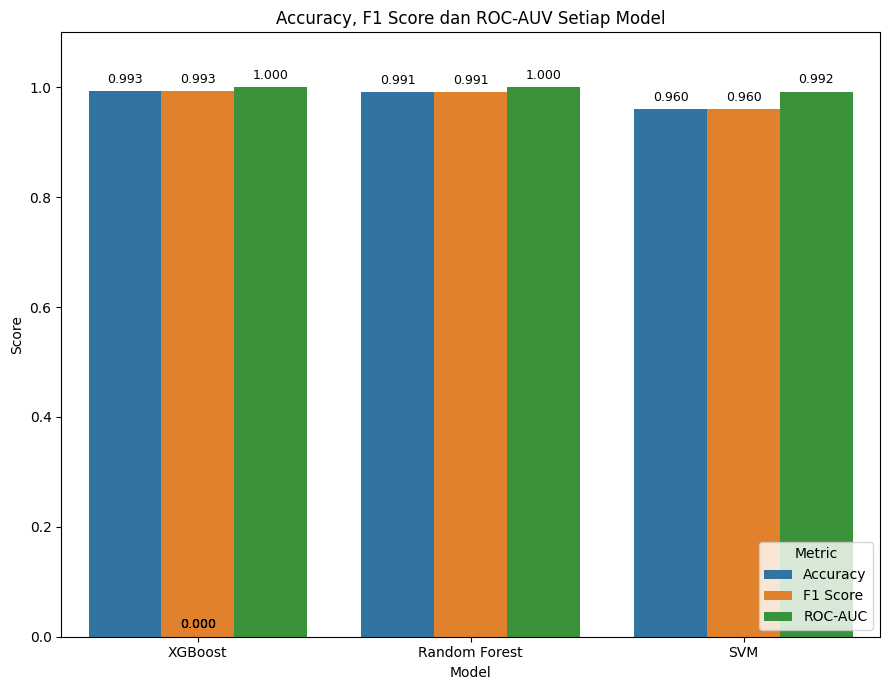

In [57]:
# Ubah dataframe ke format long agar bisa digunakan di seaborn barplot
results_long = best_results_df.melt(id_vars='Model', value_vars=['Accuracy', 'F1 Score', 'ROC-AUC'],
                               var_name='Metric', value_name='Score')

# Buat bar plot
plt.figure(figsize=(9, 7))
ax = sns.barplot(data=results_long, x='Model', y='Score', hue='Metric')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2,
            height + 0.01,
            f'{height:.3f}',
            ha='center', va='bottom', fontsize=9)
# Tambahkan judul dan label
plt.title('Accuracy, F1 Score dan ROC-AUV Setiap Model')
plt.ylabel('Score')
plt.ylim(0, 1.1)  # Tambah batas atas agar label tidak terpotong
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


# Confusion Matrix

In [60]:
def plot_conf_matrix(y_true, y_pred, model_name,):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

Evaluating model: SVM
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       517
           1       0.98      0.94      0.96       517

    accuracy                           0.96      1034
   macro avg       0.96      0.96      0.96      1034
weighted avg       0.96      0.96      0.96      1034



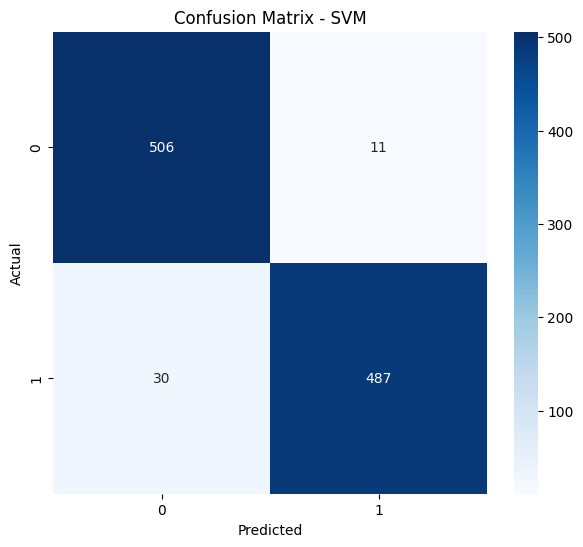

Evaluating model: Random Forest
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       517
           1       1.00      0.98      0.99       517

    accuracy                           0.99      1034
   macro avg       0.99      0.99      0.99      1034
weighted avg       0.99      0.99      0.99      1034



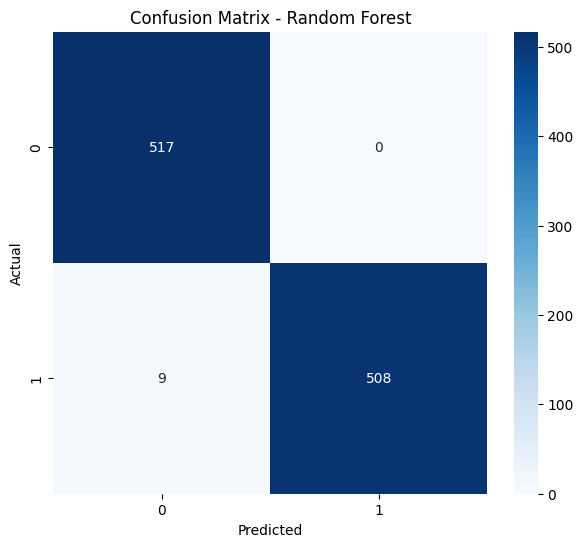

Evaluating model: XGBoost
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       517
           1       1.00      0.99      0.99       517

    accuracy                           0.99      1034
   macro avg       0.99      0.99      0.99      1034
weighted avg       0.99      0.99      0.99      1034



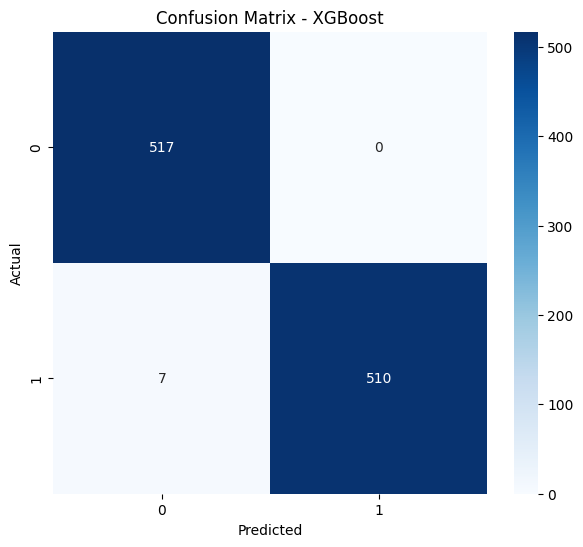

In [63]:
for name, model in best_models.items():
    print(f"Evaluating model: {name}")
    y_pred = model.predict(X_test)

    # Print classification report
    print(classification_report(y_test, y_pred))

    # Tampilkan confusion matrix
    plot_conf_matrix(y_test, y_pred, name)